In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV

sns.set()

## 1. Load Dataset

In [2]:
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## 2. EDA

In [4]:
# Check number of null values of each column
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [5]:
# Convert created_at and last_move_at from float to datetime
df['created_at']    = pd.to_datetime(df['created_at']/1000,  unit='s',  origin='unix')
df['last_move_at']  = pd.to_datetime(df['last_move_at']/1000,  unit='s',  origin='unix')
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [6]:
print(f"Dates are equal: {(df['created_at'] == df['last_move_at']).sum()} instances")
print(f"Dates are not equal: {(df['created_at'] != df['last_move_at']).sum()} instances")

Dates are equal: 8548 instances
Dates are not equal: 11510 instances


In [7]:
# Get the amount of time each match takes
df['duration'] = (df['last_move_at'] - df['created_at']).dt.total_seconds()
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.0
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.0
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.0
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.0


In [8]:
df['duration'].value_counts()

0.000        8548
10000.000     734
1233.139        3
260.178         3
1000.942        3
             ... 
956.946         1
142.205         1
636.600         1
204.020         1
736.699         1
Name: duration, Length: 10338, dtype: int64

It seems that the timestamps for created_at and last_move_at are highly inaccurate. This is because in over 80% of instances, there is no time difference between created_at and last_move_at.

Therefore, we will drop all these columns since they are unusable.

In [9]:
df.drop(columns=['created_at', 'last_move_at', 'duration'], inplace=True)

In [10]:
# Extract increment code to get start time limit (mins) and increment (secs)
inc_extracted = df['increment_code'].str.split("+")
df['start_time_limit'] = [int(x[0]) for x in inc_extracted]
df['increment'] = [int(x[1]) for x in inc_extracted]
df.drop(columns='increment_code', inplace=True)

In [11]:
# Get list of moves per match and extract first moves of white and black players
df['moves_list'] = df['moves'].str.split(" ")
df['white_first_move'] = [x[0] for x in df['moves_list']]
df['black_first_move'] = [x[1] if len(x)>=2 else None for x in df['moves_list']]
df.drop(columns='moves', inplace=True)

In [12]:
# Find the differences in terms of ratings between black and white player
# Positive value: white rating > black rating
# Negative value: white rating < black rating
df['rating_diff'] = df['white_rating'] - df['black_rating']

In [13]:
df.head()

,id,rated,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,opening_eco,opening_name,opening_ply,start_time_limit,increment,moves_list,white_first_move,black_first_move,rating_diff
0,TZJHLljE,False,13,outoftime,white,bourgris,1500,a-00,1191,D10,Slav Defense: Exchange Variation,5,15,2,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",d4,d5,309
1,l1NXvwaE,True,16,resign,black,a-00,1322,skinnerua,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",d4,Nc6,61
2,mIICvQHh,True,61,mate,white,ischia,1496,a-00,1500,C20,King's Pawn Game: Leonardis Variation,3,5,10,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",e4,e5,-4
3,kWKvrqYL,True,61,mate,white,daniamurashov,1439,adivanov2009,1454,D02,Queen's Pawn Game: Zukertort Variation,3,20,0,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",d4,d5,-15
4,9tXo1AUZ,True,95,mate,white,nik221107,1523,adivanov2009,1469,C41,Philidor Defense,5,30,3,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",e4,e5,54


In [14]:
print(f"Number of unique white players: {len(df['white_id'].unique())}")
print(f"Number of unique black players: {len(df['black_id'].unique())}")
print(f"Number of unique players: {len(set(df['white_id'].unique()) | set(df['black_id'].unique()))}")
print(f"Number of unique players who had played both black and white: {len(set(df['white_id'].unique()) & set(df['black_id'].unique()))}")

Number of unique white players: 9438
Number of unique black players: 9331
Number of unique players: 15635
Number of unique players who had played both black and white: 3134


In [15]:
df['opening_name'].value_counts()

Van't Kruijs Opening                                              368
Sicilian Defense                                                  358
Sicilian Defense: Bowdler Attack                                  296
Scotch Game                                                       271
French Defense: Knight Variation                                  271
                                                                 ... 
Sicilian Defense: Kupreichik Variation                              1
Modern Defense: Lizard Defense |  Mittenberger Gambit               1
French Defense: Rubinstein Variation |  Kasparov Attack             1
French Defense: Tarrasch Variation |  Open System |  Main Line      1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation        1
Name: opening_name, Length: 1477, dtype: int64

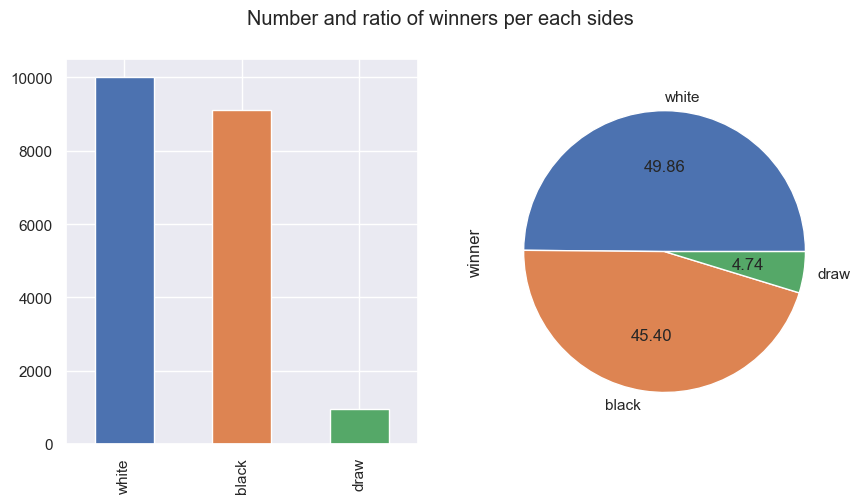

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['winner'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['winner'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of winners per each sides")
plt.show()

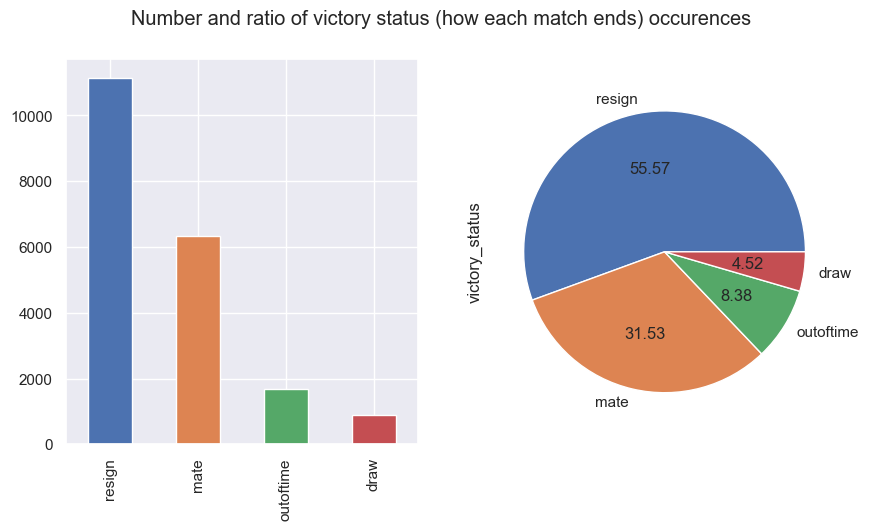

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['victory_status'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['victory_status'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of victory status (how each match ends) occurences")
plt.show()

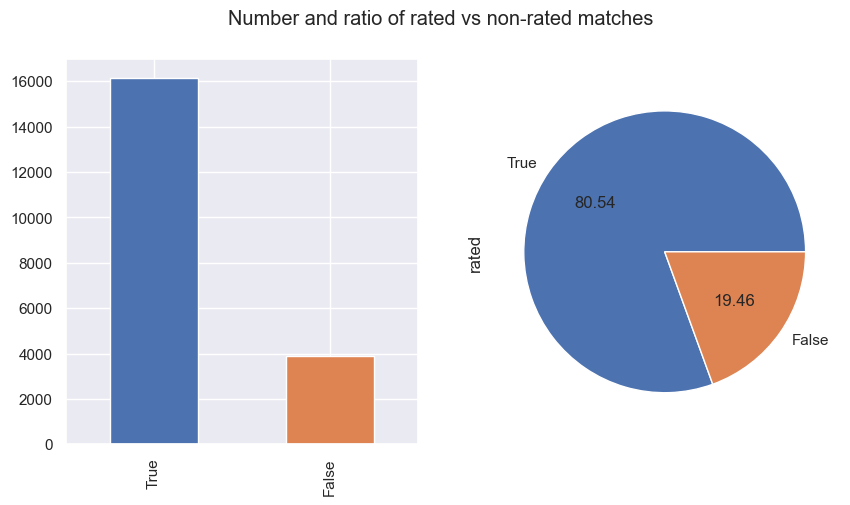

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df['rated'].value_counts().plot.bar(color=sns.color_palette(), ax=axs[0])
df['rated'].value_counts().plot.pie(autopct='%.2f', ax=axs[1])
fig.suptitle("Number and ratio of rated vs non-rated matches")
plt.show()

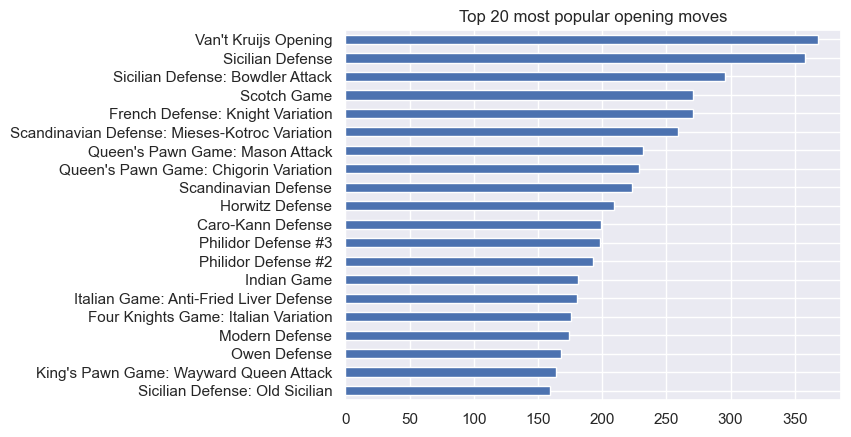

In [19]:
df['opening_name'].value_counts()[:20].sort_values().plot.barh()
plt.title("Top 20 most popular opening moves")
plt.show()

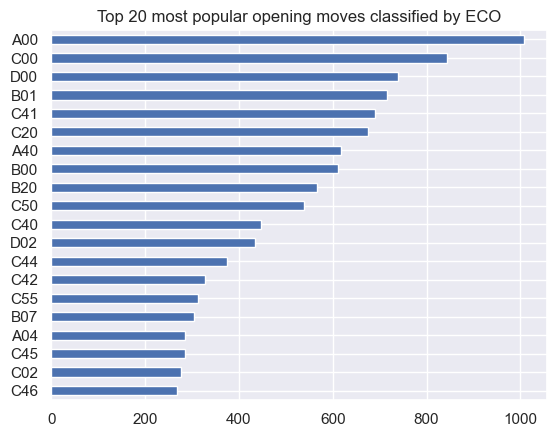

In [20]:
df['opening_eco'].value_counts()[:20].sort_values().plot.barh()
plt.title("Top 20 most popular opening moves classified by ECO")
plt.show()

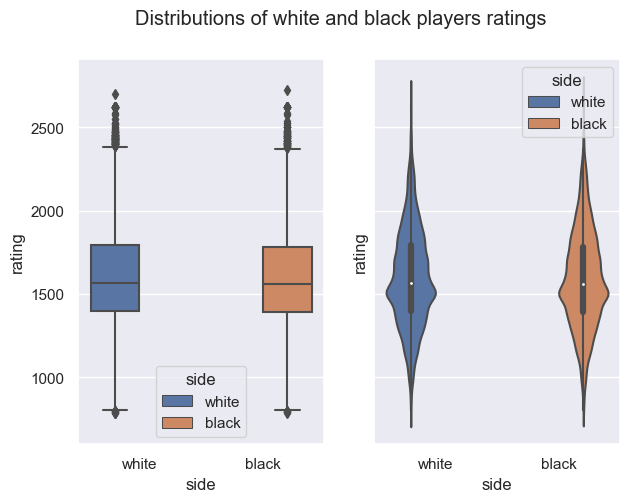

In [21]:
white_ratings = df[['white_rating']].copy().rename(columns={'white_rating': 'rating'})
white_ratings['side'] = 'white'

black_ratings = df[['black_rating']].copy().rename(columns={'black_rating': 'rating'})
black_ratings['side'] = 'black'

ratings = pd.concat([white_ratings, black_ratings]).reset_index(drop=True)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7,5))
sns.boxplot(data=ratings, x='side', y='rating', hue='side', ax=axs[0])
sns.violinplot(data=ratings, x='side', y='rating', hue='side', ax=axs[1])
fig.suptitle("Distributions of white and black players ratings")
plt.setp(axs, ylim=axs[0].get_ylim())
plt.show()

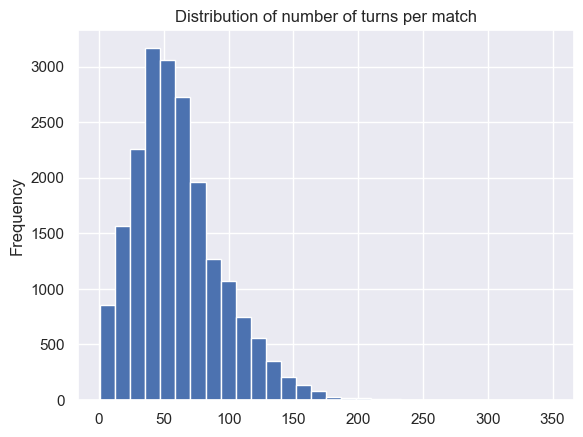

In [22]:
df['turns'].plot.hist(bins=30)
plt.title('Distribution of number of turns per match')
plt.show()

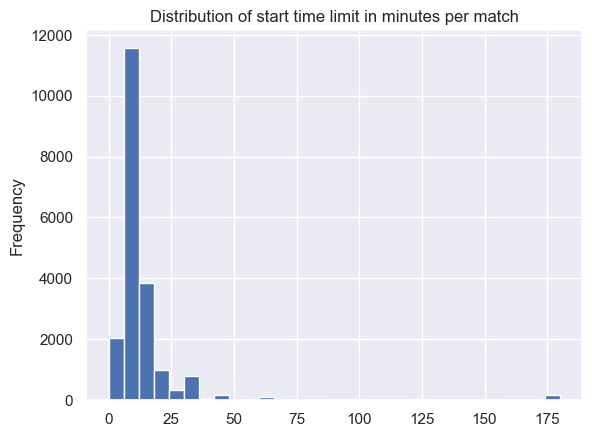

In [23]:
df['start_time_limit'].plot.hist(bins=30)
plt.title('Distribution of start time limit in minutes per match')
plt.show()

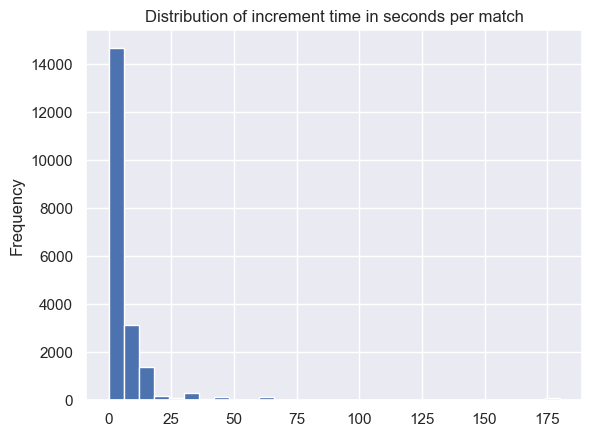

In [24]:
df['increment'].plot.hist(bins=30)
plt.title('Distribution of increment time in seconds per match')
plt.show()

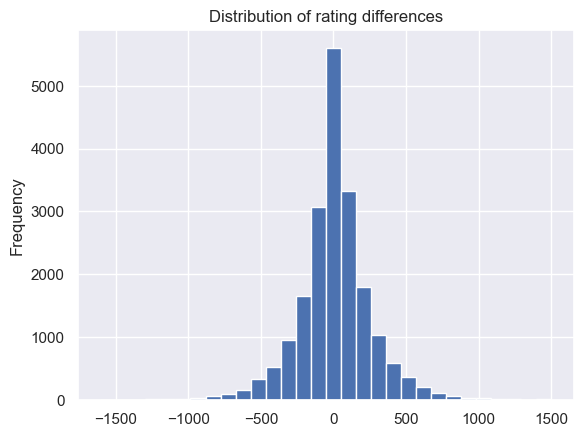

In [25]:
df['rating_diff'].plot.hist(bins=30)
plt.title('Distribution of rating differences')
plt.show()

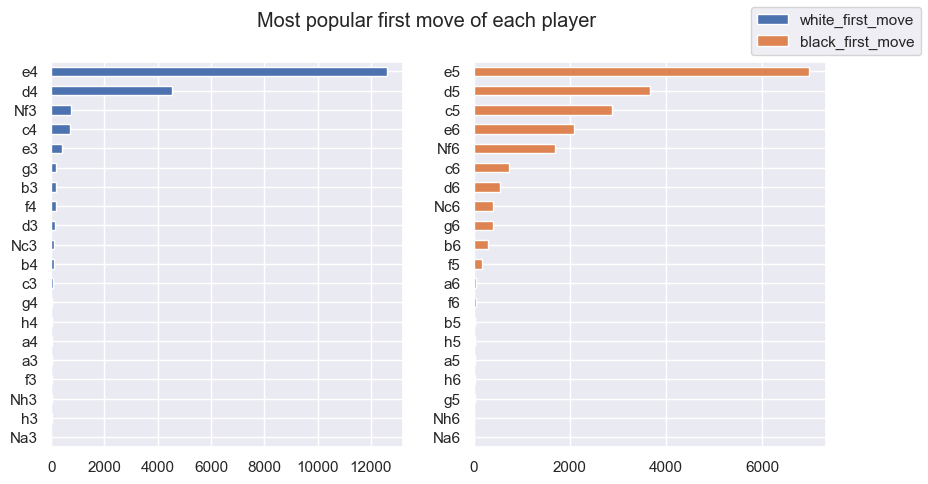

In [26]:
# In chess game, there are only 20 possible first moves for each side (16 pawn moves and 4 knight moves)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
df['white_first_move'].value_counts().sort_values().plot.barh(ax=axs[0], color=sns.color_palette()[0])
df['black_first_move'].value_counts().sort_values().plot.barh(ax=axs[1], color=sns.color_palette()[1])
fig.suptitle("Most popular first move of each player")
fig.legend()
plt.show()

In [27]:
df_player = pd.DataFrame({"player_id": list(set(df['white_id'].unique()) | set(df['black_id'].unique()))})

# Get only matches in which black wins
black_win = df[df['winner'] == 'black']
white_win = df[df['winner'] == 'white']
draw = df[df['winner'] == 'draw']

# Get number of matches that a player participated
df_player['matches_participated'] = df_player['player_id'].map(
    df['white_id'].value_counts().add(df['black_id'].value_counts(), fill_value=0))

# Get number of wins per each player when playing as black, white, overall
df_player['wins_as_black'] = df_player['player_id'].map(black_win['black_id'].value_counts()).fillna(0)
df_player['wins_as_white'] = df_player['player_id'].map(white_win['white_id'].value_counts()).fillna(0)
df_player['wins'] = df_player['wins_as_black'] + df_player['wins_as_white']
df_player['draws'] = df_player['player_id'].map(
    (draw['white_id'].value_counts() + draw['black_id'].value_counts())).fillna(0)
df_player['losses'] = df_player['matches_participated'] - df_player['wins'] - df_player['draws']

# Wins to matches participated ratio
df_player['wins_percentage'] = df_player['wins'] / df_player['matches_participated']
df_player.set_index('player_id', inplace=True)
df_player.head(10)

,matches_participated,wins_as_black,wins_as_white,wins,draws,losses,wins_percentage
player_id,,,,,,,
mocci,1.0,0.0,0.0,0.0,0.0,1.0,0.0
artem2008,1.0,1.0,0.0,1.0,0.0,0.0,1.0
kekscrafter,1.0,0.0,1.0,1.0,0.0,0.0,1.0
georgym89,1.0,0.0,0.0,0.0,0.0,1.0,0.0
wewuzkangzz,1.0,0.0,0.0,0.0,0.0,1.0,0.0
nosoygonzalo,1.0,0.0,0.0,0.0,0.0,1.0,0.0
realcs,1.0,0.0,0.0,0.0,0.0,1.0,0.0
emiracle,2.0,0.0,0.0,0.0,0.0,2.0,0.0
hugolin,2.0,0.0,1.0,1.0,0.0,1.0,0.5


In [28]:
top_players = df_player.sort_values('wins', ascending=False)

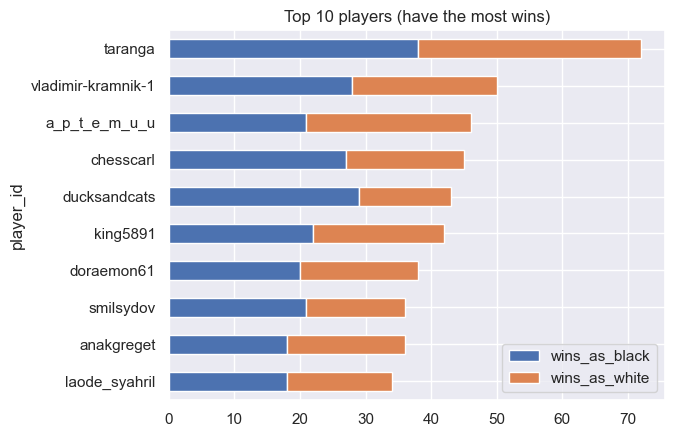

In [29]:
top_players[['wins_as_black', 'wins_as_white']][:10][::-1].plot.barh(stacked=True)
plt.title("Top 10 players (have the most wins)")
plt.show()

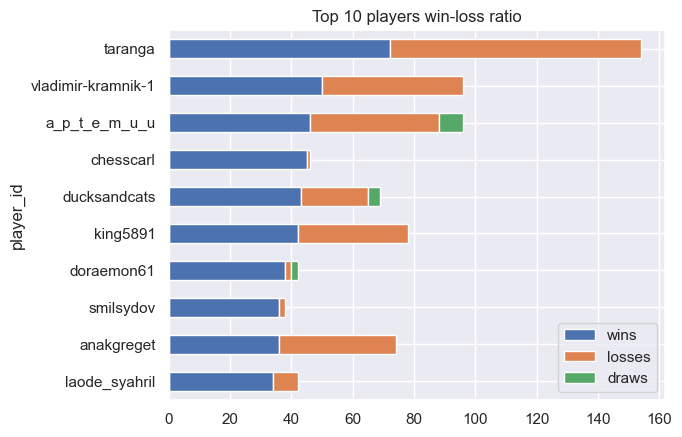

In [30]:
top_players[['wins', 'losses', 'draws']][:10][::-1].plot.barh(stacked=True)
plt.title("Top 10 players win-loss ratio")
plt.show()

## 3. Features Selection

First, we will select subset of matches which did not end in draw.

Next, we exclude matches that ended in one move (black did not move and withdraw)

We will define all features which will be used for chess winning rate predictions.

Features should include all metagame data such as player ratings, start time limit and increments, each player first move, etc.

Features should exclude post-match data such as number of turns and victory status.

In [66]:
subset = df[(df['winner'] != 'draw') & (df['black_first_move'].notna())].copy().reset_index(drop=True)
X = subset[['rated', 'white_rating', 'black_rating', 'start_time_limit', 'increment', 'white_first_move', 'black_first_move']]
y = subset['winner']
X.shape, y.shape

((19090, 7), (19090,))

In [67]:
df['increment'].max()

180

In [68]:
# We encode the target winner into binary numerical value
# 0: Black is the winner
# 1: White is the winner

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)
y

array([1, 0, 1, ..., 1, 1, 0])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14317, 7) (4773, 7)
(14317,) (4773,)


In [70]:
X

,rated,white_rating,black_rating,start_time_limit,increment,white_first_move,black_first_move
0,False,1500,1191,15,2,d4,d5
1,True,1322,1261,5,10,d4,Nc6
2,True,1496,1500,5,10,e4,e5
3,True,1439,1454,20,0,d4,d5
4,True,1523,1469,30,3,e4,e5
...,...,...,...,...,...,...,...
19085,True,1691,1220,10,10,d4,f5
19086,True,1233,1196,10,0,d4,d6
19087,True,1219,1286,10,0,d4,d5
19088,True,1360,1227,10,0,e4,d6


## 4. Data Preprocessing

In [71]:
num_cols = ['white_rating', 'black_rating', 'start_time_limit', 'increment']
cat_cols = ['rated', 'white_first_move', 'black_first_move']

feat_en_cols = ['white_rating', 'black_rating']
oe_cols = ['rated']
ohe_cols = ['white_first_move', 'black_first_move']

In [77]:
imputers = ColumnTransformer(transformers=[
    ('numeric_imputer', SimpleImputer(missing_values=np.nan, strategy='median'), num_cols),
    ('categorical_imputer', SimpleImputer(missing_values=None, strategy='most_frequent'), cat_cols)  # Scale all numerical features
    ],
    verbose_feature_names_out=False).set_output(transform='pandas')

In [78]:
transformers = ColumnTransformer(transformers=[
    ('numeric_scaler', RobustScaler(), num_cols),
    ('rated_binary_encoder', OrdinalEncoder(), oe_cols),    # Transform rated feature into binary numerical value (0: False, 1: True)
    ('first_moves_onehot_encoder', OneHotEncoder(handle_unknown='error', sparse_output=False), ohe_cols)    # We will apply one hot encoding on white_first_move and black_first_move features
    ],  
    verbose_feature_names_out=False,
    remainder='passthrough').set_output(transform='pandas')

In [79]:
def create_rating_diff(df):
    df = df.copy()
    df['rating_diff'] = df['white_rating'] - df['black_rating']
    return df

In [80]:
preprocessor = Pipeline(steps=[
    ('imputers', imputers),
    ('feature_engineering', FunctionTransformer(create_rating_diff)),
    ('transformers', transformers)
])

In [81]:
preprocessor.fit_transform(X_train)

,white_rating,black_rating,start_time_limit,increment,rated,white_first_move_Na3,white_first_move_Nc3,white_first_move_Nf3,white_first_move_Nh3,white_first_move_a3,...,black_first_move_d6,black_first_move_e5,black_first_move_e6,black_first_move_f5,black_first_move_f6,black_first_move_g5,black_first_move_g6,black_first_move_h5,black_first_move_h6,rating_diff
7928,-0.345269,-0.380102,-0.6,1.142857,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
10609,0.035806,-0.002551,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
13415,-0.161125,-0.040816,0.0,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-44.0
5705,0.322251,0.364796,-1.0,0.857143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0
7707,0.795396,0.742347,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16332,0.140665,-0.051020,-1.0,0.714286,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0
2341,-0.654731,-0.734694,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0
17676,0.212276,0.380102,-1.0,1.142857,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-63.0
8502,0.150895,0.341837,2.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-72.0


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [42]:
models = [LogisticRegression(max_iter=5000), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
kfold = KFold(n_splits=5, shuffle=True)

In [43]:
print("=====F1-score=====")
for model in models:
    pipe = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='f1')
    print(f"{model.__class__.__name__} - Score: {scores}; Mean: {scores.mean()}")

=====F1-score=====
LogisticRegression - Score: [0.67322335 0.66666667 0.68897387 0.68950206 0.69301296]; Mean: 0.6822757819065697
DecisionTreeClassifier - Score: [0.60285132 0.62285337 0.61405261 0.62080537 0.61724254]; Mean: 0.6155610423261763
RandomForestClassifier - Score: [0.65673663 0.6633433  0.67555267 0.6790728  0.68725618]; Mean: 0.6723923157633122
GradientBoostingClassifier - Score: [0.68254466 0.69185868 0.68307884 0.69441875 0.70344828]; Mean: 0.6910698400996078


In [44]:
print("=====Negative Cross-Entropy Loss=====")
for model in models:
    pipe = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='neg_log_loss')
    print(f"{model.__class__.__name__} - Score: {scores}; Mean: {scores.mean()}")

=====Negative Cross-Entropy Loss=====
LogisticRegression - Score: [-0.61388346 -0.62168609 -0.61216388 -0.61198951 -0.61503468]; Mean: -0.6149515230300214
DecisionTreeClassifier - Score: [-14.28684517 -14.36227337 -14.24226311 -14.28000898 -14.3823148 ]; Mean: -14.310741086493664
RandomForestClassifier - Score: [-0.63101312 -0.64144707 -0.63784667 -0.64176909 -0.63532617]; Mean: -0.6374804262515511
GradientBoostingClassifier - Score: [-0.61374672 -0.62032298 -0.60732665 -0.61171859 -0.61074949]; Mean: -0.6127728868090209


In [45]:
# Select best performing model using default hyperparameters
clf = GradientBoostingClassifier()
best_pipe = make_pipeline(preprocessor, clf)

best_pipe.fit(X_train, y_train)
# Test score of best performing model using default hyperparameters
print(f"Accuracy: {best_pipe.score(X_test, y_test)}")

Accuracy: 0.6513723025350933


In [47]:
# Select best performing model
clf = GradientBoostingClassifier()

# Specify hyperparameters for grid search
param_grid = {
    'n_estimators': [3, 10, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_depth' : [1, 3, 5, 10]}

pipe_grid = {}

# adding the prefix '{classifier_name}__' to each hyperparameter
for param in param_grid.keys():
    new_param = clf.__class__.__name__.lower()+'__'+param
    pipe_grid[new_param] = param_grid[param]


pipe = make_pipeline(preprocessor, clf)
grid = GridSearchCV(pipe, pipe_grid, cv=kfold)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('feature_engineering',
                                                         FunctionTransformer(func=<function create_rating_diff at 0x000001EFE6F54430>)),
                                                        ('transformers',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('numeric_transformer',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImpu...
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'squared_error'],
                         'gradientboostingclassifier__max_depth': [1, 3, 5, 10],
                         'gradientboostingclassifier__min_samples_leaf': [1, 2,
                                                                          3],
                         'gradientboostingclassifier__min_samples_split': [2, 4,
                                                                           6],
                         'gradientboostingclassifier__n_estimators': [3, 10,
                                                                      100]})

In [48]:
# Get the best values for each hyperparameter
grid.best_params_

{'gradientboostingclassifier__criterion': 'squared_error',
 'gradientboostingclassifier__max_depth': 10,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__n_estimators': 100}

In [52]:
best_param = {}
for param in grid.best_params_:
    new_param = param.removeprefix('gradientboostingclassifier__')
    best_param[new_param] = grid.best_params_[param]

# Select best performing model using best hyperparameters
clf = GradientBoostingClassifier(**best_param)
best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)])

best_pipe.fit(X_train, y_train)
# Test score of best performing model using best hyperparameters
print(f"Accuracy: {best_pipe.score(X_test, y_test)}")

Accuracy: 0.6507437670228368


In [65]:
results = pd.DataFrame({"actual_winner": y_test})

results['pred_winner'] = best_pipe.predict(X_test)
results['pred_white_win_rate'] = best_pipe.predict_proba(X_test)[:, 1]
results

,actual_winner,pred_winner,pred_white_win_rate
0,0,1,0.717246
1,0,1,0.692097
2,0,1,0.586633
3,0,0,0.352777
4,0,0,0.238492
...,...,...,...
4768,0,0,0.453069
4769,0,0,0.346203
4770,1,0,0.461731
4771,1,0,0.233497


In [54]:
# Save the model pipeline
with open('chess_winner_predictor.pkl','wb') as f:
    pickle.dump(best_pipe, f)

In [3]:
def create_rating_diff(df):
    df = df.copy()
    df['rating_diff'] = df['white_rating'] - df['black_rating']
    return df

In [4]:
model = pickle.load(open('chess_winner_predictor.pkl', 'rb'))

In [49]:
list(model[0][1].transformers_[-2][1].categories_[1])

['Na6',
 'Nc6',
 'Nf6',
 'Nh6',
 'a5',
 'a6',
 'b5',
 'b6',
 'c5',
 'c6',
 'd5',
 'd6',
 'e5',
 'e6',
 'f5',
 'f6',
 'g5',
 'g6',
 'h5',
 'h6']

In [54]:
eval('True')

True